# 08wk-1: 이미지분석 (2)

최규빈  
2022-10-20

> Minor topics in CNN– 다중클래스분류 (BCELoss vs CELoss), fastai metric
> 사용

# 강의영상

> <https://youtube.com/playlist?list=PLQqh36zP38-wVdrvMFFtAcAM2QC7ZpnN3>

# imports

In [2]:
import torch 
import torchvision
import numpy as np
from fastai.vision.all import * 

In [3]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }');

# CNN 다중클래스 분류

## 결론 (그냥 외우세요)

`-` 2개의 class를 구분하는 문제가 아니라 $k$개의 class를 구분해야
한다면?

***일반적인 개념***

-   손실함수: BCE loss $\to$ Cross Entropy loss
-   마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k)
-   마지막층의 활성화: sig $\to$ softmax

***파이토치 한정***

-   **y의형태: (n,) vector + int형 // (n,k) one-hot encoded vector +
    float형**
-   손실함수: torch.nn.BCEWithLogitsLoss, $\to$
    torch.nn.CrossEntropyLoss
-   마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k)
-   마지막층의 활성화: None $\to$ None (손실함수에 이미 마지막층의
    활성화가 포함)

## 실습: 3개의 클래스를 구분

In [10]:
path = untar_data(URLs.MNIST)

training set

In [14]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2])/255
y = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))#.reshape(-1,1)

test set

In [12]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/2').ls()])
XX = torch.concat([X0,X1,X2])/255
yy = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))#.reshape(-1,1)

`(1)` dls

In [29]:
len(X)

In [30]:
ds1 = torch.utils.data.TensorDataset(X,y) 
ds2 = torch.utils.data.TensorDataset(XX,yy) 
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1862) # 에폭당 11번 iter
dl2 = torch.utils.data.DataLoader(ds2,batch_size=3147) # 
dls = DataLoaders(dl1,dl2) 

`(2)` lrnr

In [31]:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)

In [32]:
net1(X).shape

In [33]:
net = torch.nn.Sequential(
    net1,
    torch.nn.Linear(2304,3) # 0,1,2 3개를 구분하는 문제이므로 out_features=3 
)
loss_fn = torch.nn.CrossEntropyLoss() 

In [38]:
lrnr = Learner(dls,net,loss_fn) 

`(3)` 학습

In [39]:
lrnr.fit(10) 

`(4)` 예측

In [41]:
lrnr.model.to("cpu")

In [50]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy) 

In [51]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy).query('y==0')

-   대체적으로 첫번째 칼럼의 숫자들이 다른칼럼보다 크다.

In [52]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy).query('y==1')

-   대체적으로 두번째 칼럼의 숫자들이 다른칼럼보다 크다.

In [53]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy).query('y==2')

-   대체적으로 세번째 칼럼의 숫자들이 다른칼럼보다 크다.

`-` 예측하는방법?

-   칼럼0의 숫자가 크다 -\> y=0일 확률이 큼
-   칼럼1의 숫자가 크다 -\> y=1일 확률이 큼
-   칼럼2의 숫자가 크다 -\> y=2일 확률이 큼

## 공부: Softmax

`-` 눈치: softmax를 쓰기 직전의 숫자들은 (n,k)꼴로 되어있음. 각
observation 마다 k개의 숫자가 있는데, 그중에서 유난히 큰 하나의 숫자가
있음.

`-` torch.nn.Softmax() 손계산

(예시1) – 잘못계산

In [56]:
sftmax = torch.nn.Softmax(dim=0)

In [57]:
_netout = torch.tensor([[-2.0,-2.0,0.0],
                        [3.14,3.14,3.14],
                        [0.0,0.0,2.0],
                        [2.0,2.0,4.0],
                        [0.0,0.0,0.0]])
_netout

In [58]:
sftmax(_netout) 

(예시2) – 이게 맞게 계산되는 것임

In [59]:
sftmax = torch.nn.Softmax(dim=1)

In [60]:
_netout

In [62]:
sftmax(_netout)

(예시3) – 차원을 명시안하면 맞게 계산해주고 경고 줌

In [63]:
sftmax = torch.nn.Softmax()

In [64]:
_netout

In [65]:
sftmax(_netout)

/home/cgb4/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.

(예시4) – 진짜 손계산

In [66]:
_netout 

In [71]:
torch.exp(_netout)

In [72]:
0.1353/(0.1353 + 0.1353 + 1.0000), 0.1353/(0.1353 + 0.1353 + 1.0000), 1.0000/(0.1353 + 0.1353 + 1.0000) # 첫 obs

In [81]:
np.exp(_netout[1])/np.exp(_netout[1]).sum() # 두번째 obs 

In [82]:
np.apply_along_axis(lambda x: np.exp(x) / np.exp(x).sum(),1,_netout)

## 공부: CrossEntropyLoss

### `#` ***torch.nn.CrossEntropyLoss() 손계산: one-hot version***

In [83]:
loss_fn = torch.nn.CrossEntropyLoss()

In [84]:
_netout

In [90]:
_y_onehot = torch.tensor([[0,0,1],
                          [0,1,0],
                          [0,0,1],
                          [0,0,1],
                          [1,0,0]])*1.0
_y_onehot

In [91]:
sftmax = torch.nn.Softmax(dim=1) 
sftmax(_netout), _y_onehot

`-` 계산결과

In [92]:
loss_fn(_netout,_y_onehot)

In [101]:
- torch.sum(torch.log(sftmax(_netout)) * _y_onehot)/5 

`-` 계산하는 방법도 중요한데 torch.nn.CrossEntropyLoss() 에는 softmax
활성화함수가 이미 포함되어 있다는 것을 확인하는 것이 더 중요함.

`-` 따라서 torch.nn.CrossEntropyLoss() 는 사실
torch.nn.CEWithSoftmaxLoss() 정도로 바꾸는 것이 더 말이 되는 것 같다.

### `#` ***torch.nn.CrossEntropyLoss() 손계산: lenght $n$ vertor version***

In [102]:
_netout 

In [108]:
_y = torch.tensor([2,1,2,2,0])

In [109]:
loss_fn(_netout,_y)

## 실습: $k=2$로 두면 이진분류도 가능

`-` download data

In [119]:
path = untar_data(URLs.MNIST) 

training

In [192]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0]*len(X0) + [1]*len(X1))#.reshape(-1,1)

In [203]:
y_onehot = torch.nn.functional.one_hot(y).float()
#y_onehot = torch.tensor(list(map(lambda x: [1,0] if x==0 else [0,1],y))).float()

test

In [204]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0]*len(X0) + [1]*len(X1))#.reshape(-1,1)

In [205]:
yy_onehot = torch.nn.functional.one_hot(yy).float()
#yy_onehot = torch.tensor(list(map(lambda x: [1,0] if x==0 else [0,1],yy))).float()

`(1)` dls

In [206]:
ds1 = torch.utils.data.TensorDataset(X,y_onehot) 
ds2 = torch.utils.data.TensorDataset(XX,yy_onehot) 
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1862) # 에폭당 11번 iter
dl2 = torch.utils.data.DataLoader(ds2,batch_size=3147) # 
dls = DataLoaders(dl1,dl2) 

`(2)` lrnr

In [207]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2)
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls,net,loss_fn) 

`(3)` 학습

In [214]:
lrnr.fit(10) 

`(4)` 예측 및 시각화

In [216]:
lrnr.model.to("cpu")

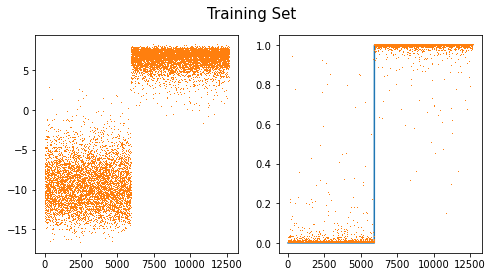

In [238]:
sftmax = torch.nn.Softmax(dim=1) 
sig = torch.nn.Sigmoid()
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(X).diff(axis=1).data,',',color="C1")
ax[1].plot(y)
ax[1].plot(sftmax(net(X))[:,1].data,',')
#ax[1].plot(sig(net(X).diff(axis=1)).data,',')
fig.suptitle("Training Set",size=15)

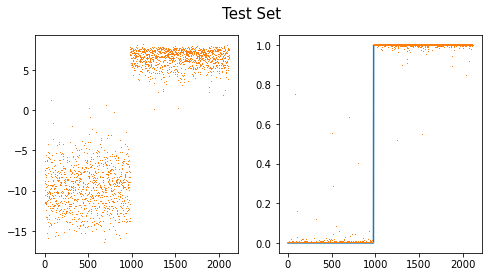

In [239]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(XX).diff(axis=1).data,',',color="C1")
ax[1].plot(yy)
ax[1].plot(sftmax(net(XX))[:,1].data,',')
#ax[1].plot(sig(net(XX).diff(axis=1)).data,',')
fig.suptitle("Test Set",size=15)

`-` note: softmax(u1,u2)=\[sig(u1-u2),
sig(u2-u1)\]=\[1-sig(u2-u1),sig(u2-u1)\]

## 공부: 이진분류에서 소프트맥스 vs 시그모이드

`-` 이진분류문제 = “y=0 or y=1” 을 맞추는 문제 = 성공과 실패를 맞추는
문제 = 성공확률과 실패확률을 추정하는 문제

`-` softmax, sigmoid

-   softmax: (실패확률, 성공확률) 꼴로 결과가 나옴 // softmax는
    실패확률과 성공확률을 둘다 추정한다.
-   sigmoid: (성공확률) 꼴로 결과가 나옴 // sigmoid는 성공확률만
    추정한다.

`-` 그런데 “실패확률=1-성공확률” 이므로 사실상 둘은 같은걸 추정하는
셈이다. (성공확률만 추정하면 실패확률은 저절로 추정되니까)

`-` 아래는 사실상 같은 모형이다.

In [7]:
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "?"
    "??"
    ".."
    "???"
    label = "Layer ?"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "?" -> "node1"
    "??" -> "node1"
    ".." -> "node1"
    "???" -> "node1"
    
    "?" -> "node2"
    "??" -> "node2"
    ".." -> "node2"
    "???" -> "node2"
    
    "?" -> "..."
    "??" -> "..."
    ".." -> "..."
    "???" -> "..."
    
    "?" -> "node2304"
    "??" -> "node2304"
    ".." -> "node2304"
    "???" -> "node2304"

    label = "Layer: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y1"
    "node2" -> "y1"
    "..." -> "y1"
    "node2304" -> "y1"
    
    "node1" -> "y2"
    "node2" -> "y2"
    "..." -> "y2"
    "node2304" -> "y2"    
    label = "Layer: Softmax"
}
''')

In [6]:
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "?"
    "??"
    ".."
    "???"
    label = "Layer ?"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "?" -> "node1"
    "??" -> "node1"
    ".." -> "node1"
    "???" -> "node1"
    
    "?" -> "node2"
    "??" -> "node2"
    ".." -> "node2"
    "???" -> "node2"
    
    "?" -> "..."
    "??" -> "..."
    ".." -> "..."
    "???" -> "..."
    
    "?" -> "node2304"
    "??" -> "node2304"
    ".." -> "node2304"
    "???" -> "node2304"

    label = "Layer: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node2304" -> "y"
    label = "Layer: Sigmoid"
}
''')

`-` 둘은 사실상 같은 효과를 주는 모형인데 학습할 파라메터는 sigmoid의
경우가 더 적다. $\to$ sigmoid를 사용하는 모형이 비용은 싸고 효과는
동일하다는 말 $\to$ 이진분류 한정해서는 softmax를 쓰지말고 sigmoid를
써야함.

-   softmax가 갑자기 너무 안좋아보이는데 sigmoid는 k개의 클래스로 확장이
    불가능한 반면 softmax는 확장이 용이하다는 장점이 있음

## 소프트맥스 vs 시그모이드 정리

`-` 결론

1.  소프트맥스는 시그모이드의 확장이다.
2.  클래스의 수가 2개일 경우에는 (Sigmoid, BCEloss) 조합을 사용해야 하고
    클래스의 수가 2개보다 클 경우에는 (Softmax, CrossEntropyLoss) 를
    사용해야 한다.

`-` 그런데 사실.. 클래스의 수가 2개일 경우일때 (Softmax,
CrossEntropyLoss)를 사용해도 그렇게 큰일나는것은 아니다. (흑백이미지를
칼라잉크로 출력하는 느낌)

***참고***

|               $y$               |            분포가정             | 마지막층의 활성화함수 |   손실함수    |
|:-------------------------------:|:-------------------------------:|:---------------------:|:-------------:|
|     3.45, 4.43, … (연속형)      |            정규분포             |  None (or Identity)   |      MSE      |
|             0 or 1              | 이항분포 with $n=1$ (=베르누이) |        Sigmoid        |      BCE      |
| \[0,0,1\], \[0,1,0\], \[1,0,0\] |       다항분포 with $n=1$       |        Softmax        | Cross Entropy |

# fastai metric 사용

## 데이터준비

`-` download data

In [244]:
path = untar_data(URLs.MNIST)

`-` training set

In [245]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

`-` test set

In [246]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [247]:
X.shape,XX.shape,y.shape,yy.shape

## 사용자정의 메트릭이용

`(1)` dls 만들기

In [248]:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

`(2)` lrnr 생성

In [249]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss() 

In [257]:
def acc(yhat,y) : 
    return ((yhat>0.5)==y).float().mean()

In [258]:
def err(yhat,y):
    return 1-((yhat>0.5)==y).float().mean()

In [259]:
lrnr = Learner(dls,net,loss_fn,metrics=[acc,err])

`(3)` 학습

In [260]:
lrnr.fit(10)

`(4)` 예측

-   생략

## fastai지원 메트릭이용– 잘못된사용

`(1)` dls 만들기

In [263]:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

`(2)` lrnr 생성

In [264]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy,error_rate])

In [265]:
accuracy??

In [266]:
error_rate??

`(3)` 학습

In [267]:
lrnr.fit(10)

-   이상하다..?

`(4)` 예측

In [268]:
lrnr.model.to("cpu")

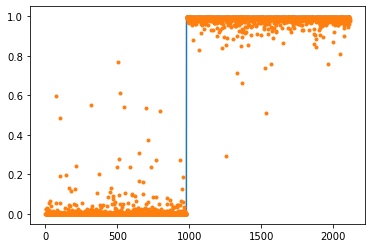

In [269]:
plt.plot(yy)
plt.plot(lrnr.model(XX).data,'.')

-   맞추는건 잘 맞추는데?

## fastai지원 메트릭이용– 올바른 사용(1)

`-` 가정

-   X의 형태는 (n,채널,픽셀,픽셀)로 가정한다.
-   y의 형태는 (n,) 벡터이다. 즉 $n\times 1$ 이 아니라 그냥 길이가 $n$인
    벡터로 가정한다.
-   y의 각 원소는 0,1,2,3,… 와 같이 카테고리를 의미하는 숫자이어야 하며
    이 숫자는 int형으로 저장되어야 한다.
-   loss function은 CrossEntropyLoss()를 쓴다고 가정한다. (따라서
    네트워크의 최종레이어는 torch.nn.Linear(?,클래스의수) 꼴이 되어야
    한다.)

`(1)` dls 만들기

In [273]:
y.to(torch.int64).reshape(-1),yy.to(torch.int64).reshape(-1)

In [275]:
ds1 = torch.utils.data.TensorDataset(X,y.to(torch.int64).reshape(-1))
ds2 = torch.utils.data.TensorDataset(XX,yy.to(torch.int64).reshape(-1))
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

`(2)` lrnr 생성

In [277]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2),
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy,error_rate])

`(3)` 학습

In [278]:
lrnr.fit(10)

## fastai지원 메트릭이용– 올바른 사용(2)

`-` 가정

-   X의 형태는 (n,채널,픽셀,픽셀)로 가정한다.
-   y의 형태는 (n,클래스의수)로 가정한다. 즉 y가 one_hot 인코딩된 형태로
    가정한다.
-   y의 각 원소는 0 혹은 1이다.
-   loss function은 CrossEntropyLoss()를 쓴다고 가정한다. (따라서
    네트워크의 최종레이어는 torch.nn.Linear(?,클래스의수) 꼴이 되어야
    한다.)

`(1)` dls 만들기

In [281]:
y_onehot = torch.tensor(list(map(lambda x: [1.0,0.0] if x==0 else [0.0,1.0], y)))
yy_onehot = torch.tensor(list(map(lambda x: [1.0,0.0] if x==0 else [0.0,1.0], yy)))
# y_onehot = torch.nn.functional.one_hot(y.reshape(-1).to(torch.int64)).to(torch.float32)
# yy_onehot = torch.nn.functional.one_hot(yy.reshape(-1).to(torch.int64)).to(torch.float32)

In [294]:
ds1 = torch.utils.data.TensorDataset(X,y_onehot)
ds2 = torch.utils.data.TensorDataset(XX,yy_onehot)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

`(2)` lrnr 생성

In [301]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2),
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss() 
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy_multi])

`(3)` 학습

In [303]:
lrnr.fit(10)